In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'          
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

### Load sales data

In [15]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [16]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [25]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO008001529,56,2018-11-07 08:03:34.147,373,SUWANA HOSPITAL,North Western Province,Puttalam,CHILAW,80,Niralini Waruna,2,The West Central Pharma (Pvt) Ltd.,238,Diclofenac Gel 20mg,10.0,170.6,194.5,0.0,0.0,1706.0,2018,November,11,7,4,Wednesday,8
1,CSO008001529,56,2018-11-07 08:03:34.147,373,SUWANA HOSPITAL,North Western Province,Puttalam,CHILAW,80,Niralini Waruna,2,The West Central Pharma (Pvt) Ltd.,238,Diclofenac Gel 20mg,0.0,170.6,194.5,1.0,1.0,0.0,2018,November,11,7,4,Wednesday,8
2,IN0066000109,0,2018-11-02 15:55:44.757,2616,Gemunu Pharmacy,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,245,hypoglycaemic sulfonylurea antidiabetic 80mg,1.0,1040.8,1186.5,0.0,0.0,1040.8,2018,November,11,2,6,Friday,15
3,IN0066000109,0,2018-11-02 15:55:44.757,2616,Gemunu Pharmacy,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,238,Diclofenac Gel 20mg,10.0,170.6,194.5,0.0,0.0,1706.0,2018,November,11,2,6,Friday,15
4,IN0066000109,0,2018-11-02 15:55:44.757,2616,Gemunu Pharmacy,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,238,Diclofenac Gel 20mg,0.0,187.8,214.0,1.0,1.0,0.0,2018,November,11,2,6,Friday,15


### What is the best Product?

In [26]:
Product_Sales = invoice_All.groupby("ItemUID").agg({'item':'max','UnitQty':'sum'}).reset_index()
#top 25 Outlet by sales value
Product_Sales = Product_Sales.nlargest(25, 'UnitQty')

In [27]:
Product_Sales

,ItemUID,item,UnitQty
23,25,Aluminum hydroxide 240ml,449574.0
189,240,nitroimidazoles GEL 30mg,418842.0
117,128,Estazolam 400,388875.0
41,43,Losartan 50mg\r\n,377527.0
128,156,sodium phosphate rectal liquid 135ml,262001.0
22,24,Ketoprofen Gel 15mg,234891.0
187,238,Diclofenac Gel 20mg,183328.0
40,42,Losartan 25mg,182409.0
59,62,Nifedipine tab 20mg,173091.0
196,247,nitroimidazoles GEL 20mg,164038.0


c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


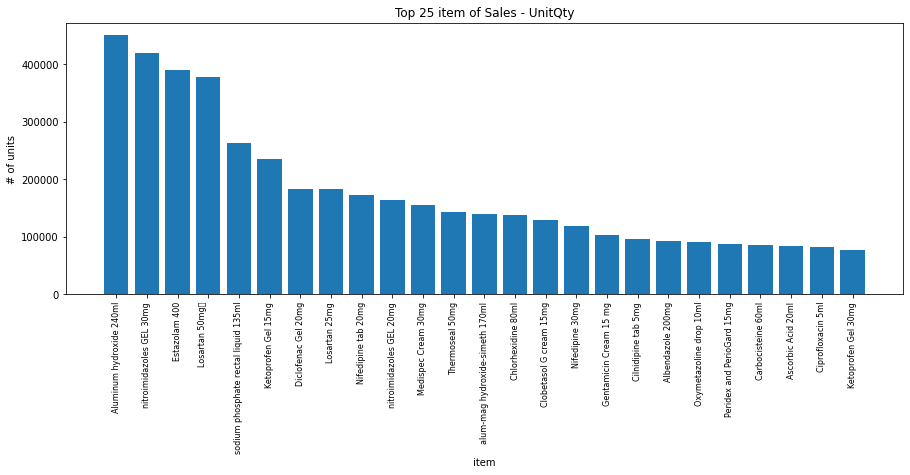

In [28]:
plt.bar(Product_Sales.item , Product_Sales.UnitQty)
plt.xlabel("item")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("# of units")
plt.title("Top 25 item of Sales - UnitQty")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [29]:
Product_Sales = invoice_All.groupby("ItemUID").agg({'item':'max','GrossValue':'sum'}).reset_index()
#top 25 Outlet by sales value
Product_Sales = Product_Sales.nlargest(25, 'GrossValue')

In [30]:
Product_Sales

,ItemUID,item,GrossValue
23,25,Aluminum hydroxide 240ml,1.156895e+08
41,43,Losartan 50mg\r\n,1.134097e+08
189,240,nitroimidazoles GEL 30mg,1.083999e+08
183,234,Nifedipine 30mg,9.120906e+07
216,269,benzoyl peroxide wash 60mg,8.767816e+07
128,156,sodium phosphate rectal liquid 135ml,7.268206e+07
22,24,Ketoprofen Gel 15mg,6.537741e+07
167,210,Carbocisteine 500mg,6.165212e+07
27,29,calcium carbonate-vitamin D3,5.955517e+07
302,501,Cilnidipine tab 5mg,5.940706e+07


c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


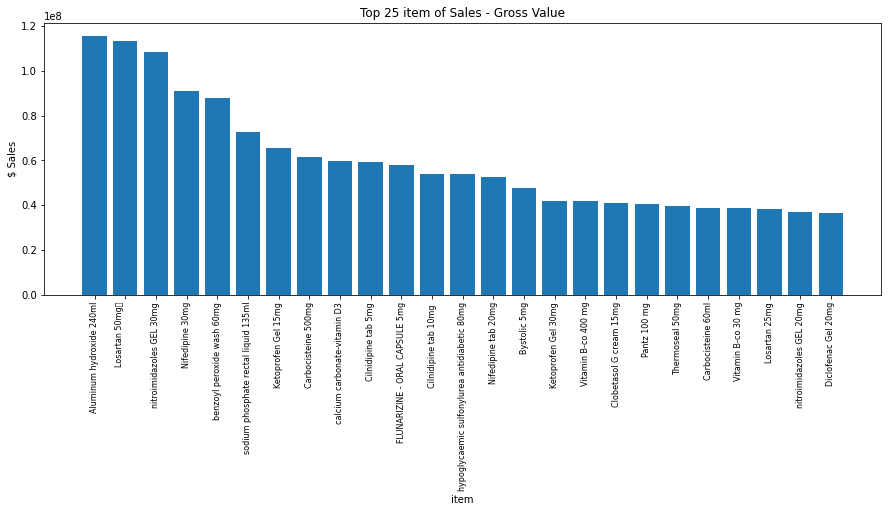

In [31]:
plt.bar(Product_Sales.item , Product_Sales.GrossValue)
plt.xlabel("item")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("$ Sales")
plt.title("Top 25 item of Sales - Gross Value")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

### Who is the best Sales Rep?

In [23]:
Rep_Sales = invoice_All.groupby("AgentUID").agg({'AgentName':'max','UnitQty':'sum'}).reset_index()
#top 25 Outlet by sales value
Rep_Sales = Rep_Sales.nlargest(25, 'UnitQty')

In [24]:
Rep_Sales

,AgentUID,AgentName,UnitQty
36,155,Desun Chamara,333677.0
16,97,Janaka Wansooriya,324480.0
37,156,,311758.0
27,110,Sithum Chamara,267687.0
38,157,Samila Vidanage,260612.0
28,112,Kulathunga Sadish,254259.0
26,109,Shalika Asitha,242917.0
39,158,Ramees Kanna,238850.0
23,104,Praneeth Waruna,237863.0
2,80,Niralini Waruna,226653.0


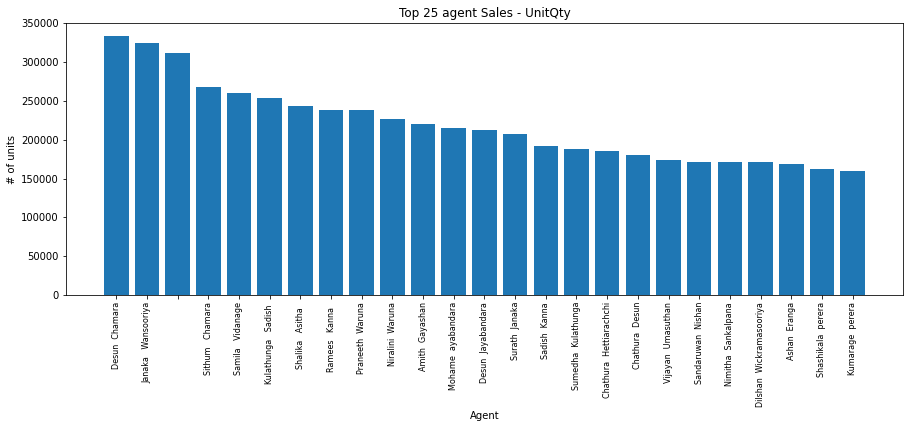

In [25]:
plt.bar(Rep_Sales.AgentName , Rep_Sales.UnitQty)
plt.xlabel("Agent")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("# of units")
plt.title("Top 25 agent Sales - UnitQty")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [26]:
Rep_Sales = invoice_All.groupby("AgentUID").agg({'AgentName':'max','GrossValue':'sum'}).reset_index()
#top 25 Outlet by sales value
Rep_Sales = Rep_Sales.nlargest(25, 'GrossValue')

In [27]:
Rep_Sales

,AgentUID,AgentName,GrossValue
16,97,Janaka Wansooriya,1.549180e+08
27,110,Sithum Chamara,1.206297e+08
19,100,Mohame ayabandara,1.117106e+08
37,156,,1.084799e+08
2,80,Niralini Waruna,1.080155e+08
26,109,Shalika Asitha,1.065859e+08
39,158,Ramees Kanna,1.060131e+08
36,155,Desun Chamara,9.816683e+07
23,104,Praneeth Waruna,9.464385e+07
38,157,Samila Vidanage,9.280831e+07


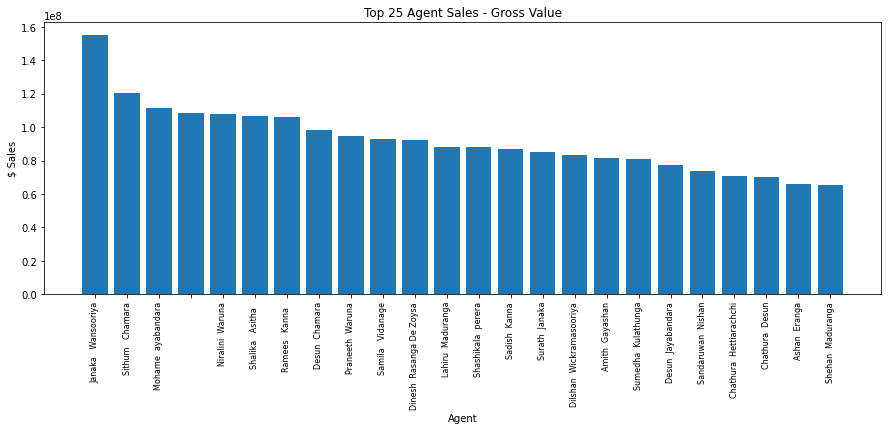

In [28]:
plt.bar(Rep_Sales.AgentName , Rep_Sales.GrossValue)
plt.xlabel("Agent")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("$ Sales")
plt.title("Top 25 Agent Sales - Gross Value")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()